In [1]:
%matplotlib inline

# Geometric Median Composites for Landsat 7 Imagery  
  
This notebook is inspired by an IEEE publication titled [High-Dimensional Pixel Composites From
Earth Observation Time Series](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8004469) authored by Dale Roberts, Norman Mueller, and Alexis McIntyre.  
  
This notebook applies this compositing method to Landsat 7 imagery, displays a rendering of the computed composites, and saves them off to disk for further validation.  


# Loading the data  

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.

In [2]:
import datacube
dc = datacube.Datacube()

> **Listing available products**  
> Lookup product/platform name to load in your data.
<br>  

In [3]:
product_listing = dc.list_products()
product_listing

,name,description,label,lon,product_type,time,creation_time,format,instrument,platform,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,None,None,LEDAPS,None,None,GeoTiff,ETM,LANDSAT_7,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Level2 Surface Ref...,None,None,LaSRC,None,None,GeoTiff,OLI_TIRS,LANDSAT_8,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"


In [4]:
platform = 'LANDSAT_7'
product = 'ls7_usgs_sr_scene'

> **Select and visualize**  
> Select and visualize the region you'll be working with.  
<br>  

In [5]:
# Zanzibar, Tanzania
lat = (-6.2238, -6.1267)
lon = (39.2298, 39.2909)

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = lat,longitude = lon)  

### Narrow down time range

In [7]:
from datetime import datetime 

date_range = ("2015-01-01", "2015-12-31")

### Load product

In [8]:
landsat_dataset = dc.load(product = product,\
                          platform = platform,\
                          lat = lat,\
                          lon = lon,\
                          time = date_range,\
                          measurements = ['red','green','nir','swir1', 'swir2','blue', 'pixel_qa'])


In [9]:
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 350, longitude: 221, time: 15)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-15T07:30:35.296858 ... 2015-12-17T07:33:13.826808
  * latitude   (latitude) float64 -6.127 -6.127 -6.127 ... -6.223 -6.223 -6.224
  * longitude  (longitude) float64 39.23 39.23 39.23 39.23 ... 39.29 39.29 39.29
Data variables:
    red        (time, latitude, longitude) int16 20000 5810 4226 ... 868 1023
    green      (time, latitude, longitude) int16 5960 5439 4037 ... 905 1134
    nir        (time, latitude, longitude) int16 7607 7165 5826 ... 2489 2783
    swir1      (time, latitude, longitude) int16 6722 6446 5062 ... 1715 1849
    swir2      (time, latitude, longitude) int16 5380 5234 3730 ... 999 1210
    blue       (time, latitude, longitude) int16 5445 4956 3672 ... 1106 713 976
    pixel_qa   (time, latitude, longitude) uint16 224 224 224 224 ... 160 96 160
Attributes:
    crs:      EPSG:4326

# Create a cloud mask  

In [10]:
from functools import reduce  
import numpy as np  

def ls7_qa_mask(dataset, keys):
    land_cover_endcoding = dict( fill     =  [1], 
                                 clear    =  [66,  130], 
                                 water    =  [68,  132],
                                 shadow   =  [72,  136],
                                 snow     =  [80,  112, 144, 176],
                                 cloud    =  [96,  112, 160, 176, 224],
                                 low_conf =  [66,  68,  72,  80,  96,  112],
                                 med_conf =  [130, 132, 136, 144, 160, 176],
                                 high_conf=  [224]
                               ) 
    def merge_lists(a, b): 
        return a.union(set(land_cover_endcoding[b]))
                        
    relevant_encodings = reduce(merge_lists, keys,set())
    return np.isin(dataset.pixel_qa.values, list(relevant_encodings)) 


In [11]:
clean_mask_np = ls7_qa_mask(landsat_dataset, ["clear", "water"])

----   

# Medoid   

> ### Geometric  Medoid Compositing   
> To compute a Geo-Medoid composite , the geometric medoid algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel( indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric medoid.  
  
> In the case of Landsat7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

>  
> 

> ### Formal Definition of a  Geometric Medoid  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{x_1,...,x_n \}$ , the medoid  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ m := argmin_{ x \in \mathbb{X}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  


### Run Medoid compositor    

In [12]:
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
medoid_mosaic = create_hdmedians_multiple_band_mosaic( landsat_dataset,
                                                       clean_mask = clean_mask_np,
                                                       operation = 'medoid')

> ### Example of a composited `swir1` band

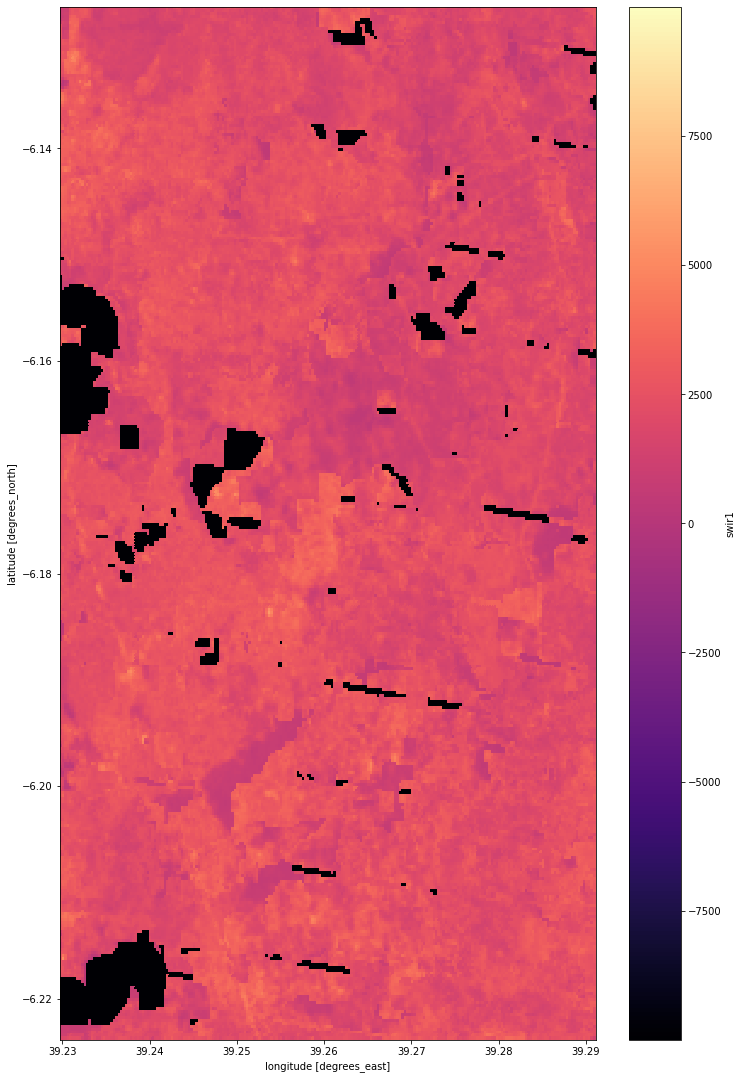

In [13]:
from utils.data_cube_utilities.plotter_utils import figure_ratio
figsize = figure_ratio(landsat_dataset, fixed_width=12)
medoid_mosaic.swir1.plot(figsize = figsize, cmap = 'magma')

----  

# Median   

> ### Geometric  Median Compositing   
> To compute a Geo-Median composite , the geometric Median algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel( indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric Median.  
  
> In the case of Landsat7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

>  
> 

> ### Formal Definition of a  Geometric Median  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{ x_1,...,x_n \}$ , the Median  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ \hat{\mu} := argmin_{ x \in \mathbb{R^{_p}}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  
> **Note:**  
> there is a subtle difference between the definition of the geometric median and the medoid: the search space for the solution differs and has the effect that the medoid returns one of the true observations whereas the geometric median can be described as a synthetic (not physically observed) observation.<sup>[[1]](#hd_medians)</sup> 


In [14]:
median_mosaic = create_hdmedians_multiple_band_mosaic(landsat_dataset,
                                               clean_mask = clean_mask_np,
                                               operation = 'median')

> ### Example of a composited `swir1` band

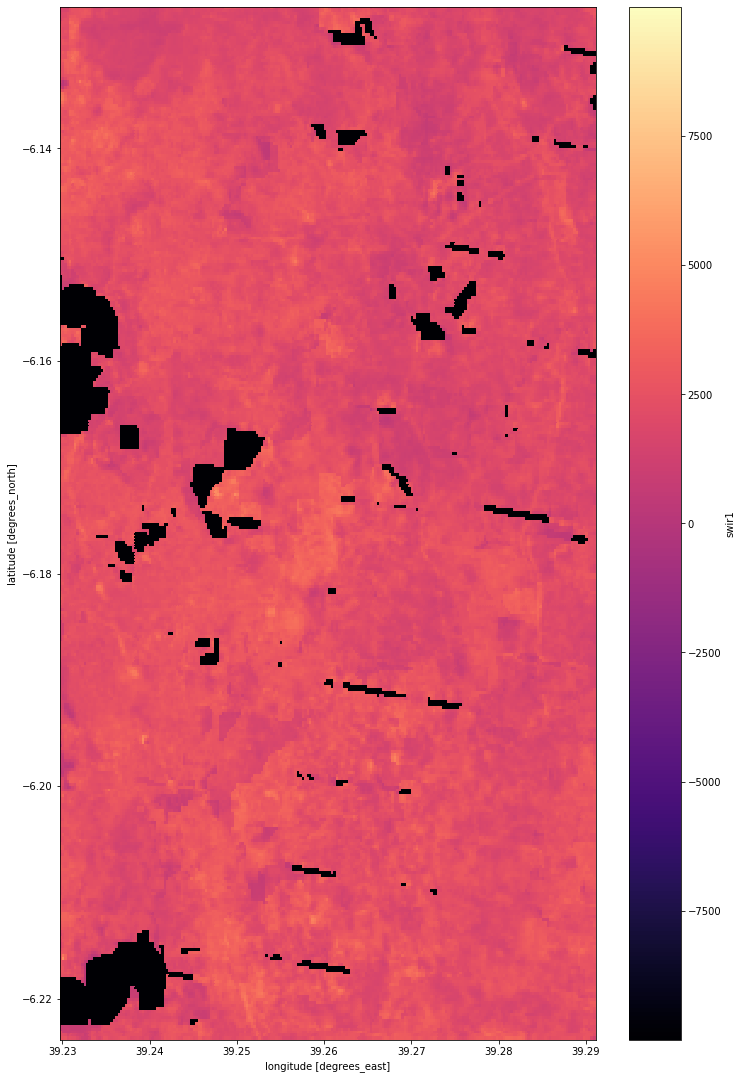

In [15]:
figsize = figure_ratio(landsat_dataset, fixed_width=12)
median_mosaic.swir1.plot(figsize = figsize, cmap = 'magma')

# Write both composites to file   
You may want to explore these files with QGIS

>### PNG  

In [16]:
import os
import pathlib
from utils.data_cube_utilities.dc_utilities import write_png_from_xr

png_dir = 'output/pngs'
pathlib.Path(png_dir).mkdir(parents=True, exist_ok=True)
write_png_from_xr('{}/geo_median.png'.format(png_dir), median_mosaic, ['red','green','blue'], scale=(0,4000))
write_png_from_xr('{}/geo_medoid.png'.format(png_dir), medoid_mosaic, ['red','green','blue'], scale=(0,4000))

>### NetCDF

In [17]:
from utils.data_cube_utilities.import_export import export_xarray_to_netcdf

output_dir = 'output/netcdfs/landsat7'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
geo_median_filepath = output_dir + '/geo_medians_ls7.nc'
export_xarray_to_netcdf(median_mosaic, geo_median_filepath)
geo_medoid_filepath = output_dir + '/geo_medoids_ls7.nc'
export_xarray_to_netcdf(medoid_mosaic, geo_medoid_filepath)

>### GeoTIFF

In [18]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

output_dir = 'output/geotiffs/landsat7'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
geo_median_filepath = output_dir + '/geo_medians_ls7.tif'
export_slice_to_geotiff(median_mosaic, geo_median_filepath)
geo_medoid_filepath = output_dir + '/geo_medoids_ls7.tif'
export_slice_to_geotiff(medoid_mosaic, geo_medoid_filepath)

In [19]:
!ls -lah output/geotiffs/landsat7/geo*.tif

-rw-r--r-- 1 jovyan users 2.1M May 21 17:01 output/geotiffs/landsat7/geo_medians_ls7.tif
-rw-r--r-- 1 jovyan users 2.1M May 21 17:01 output/geotiffs/landsat7/geo_medoids_ls7.tif


----   
# References   

<span id='hd_medians'></span>  
1. Dale Roberts 2018. Hdmedians. Github: https://github.com/daleroberts/hdmedians,  
  
2. Small, C. G. (1990). A survey of multidimensional medians. International Statistical Review/Revue Internationale de Statistique, 263-277.
